# Enhancing $\psi(2S)$ signal with a simple DNN

In the previous notebooks we have discussed the basics of `numpy`, `pandas` and `matplotlib` which provide the minimal toolset for data analysis in Python. 
Then we introduced `keras` to define and train deep neural networks. 

In this notebook we discuss a first application of keras to *Particle Physics* to enhance the signal of the $\psi(2S)$ resonance by rejecting background combining kinematic variables. 

## Loading libraries and datasets

As a first step, let's load the libraries of our toolset

In [1]:
## numpy for arrays and numerical operations 
import numpy as np 

## pandas for data handling 
import pandas as pd 

## pyplot for data visualization 
import matplotlib.pyplot as plt

## keras for deep learning
import keras as K

Then we obtain the dataset from the CERN Open Data portal ed elenchiamo le variabili presenti nel dataset.

In [2]:
df = pd.read_csv ("https://opendata.cern.ch/record/5201/files/Dimuon_DoubleMu.csv")

print ("\n".join (df.columns))

Run
Event
type1
E1
px1
py1
pz1
pt1
eta1
phi1
Q1
type2
E2
px2
py2
pz2
pt2
eta2
phi2
Q2
M


## Explorative analysis and Feature engineering
With the exception of the mass $M$, all variables are relative to either the positive or the negative muon combined into a charmonium decay candidate.
We compute the momentum and the polar angle of the combination.

In [3]:
df['p'] = df.eval("sqrt((px1 + px2)**2 + (py1 + py2)**2 + (pz1 + pz2)**2)")
df['pT'] = df.eval("sqrt((px1 + px2)**2 + (py1 + py2)**2)")
df['theta'] = df.eval(f"arcsin (pT/p) * 180 / {np.pi}")

Now that we have engineered some useful feature in our dataset let's consider the mass distribution in the charmonium region.

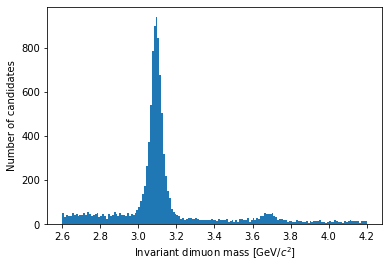

In [4]:
boundaries = np.linspace ( 2.6, 4.2, 161)
plt.hist (df['M'], bins=boundaries)
plt.xlabel ("Invariant dimuon mass [GeV/$c^2$]")
plt.ylabel ("Number of candidates")
plt.show()

We define now a background region, a control region and a signal region. 
The background region is assumed to represent reliably the residual background in the signal and in the control region. 
While the signal region offers a dataset with abundant and relatively pure decay candidates that represents well the signal. 
> **Note!** This is possible because the production mechanism of $J/\psi$ and $\psi(2S)$ is similar with differences mainly due to the small mass difference.

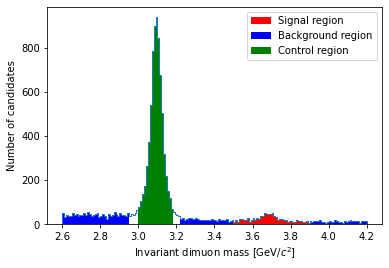

In [5]:
df_bkg = df.query ("(M > 2.6 and M < 2.95) or (M > 3.22 and M < 3.5) or (M > 3.9 and M < 4.2)").copy()
df_ctrl = df.query ("M > 3.0 and M < 3.18").copy()
df_sig = df.query ("M > 3.5 and M < 3.9").copy()
boundaries = np.linspace ( 2.6, 4.2, 161)

plt.hist (df['M'], bins=boundaries, histtype = 'step')

plt.hist (df_sig['M'], bins=boundaries, color = 'red', label = "Signal region")
plt.hist (df_bkg['M'], bins=boundaries, color = 'blue', label = "Background region")
plt.hist (df_ctrl['M'], bins=boundaries, color = 'green', label = "Control region")

plt.xlabel ("Invariant dimuon mass [GeV/$c^2$]")
plt.ylabel ("Number of candidates")
plt.legend()
plt.show()

We will try to distinguish the control sample from the combinatorial background by applying selection requirements on the kinematic variables that we engineered above: the mass and the momentum of the dimuon combination.
Let's have a look to how the three categories are distributed on the $p \perp \theta$ plane.

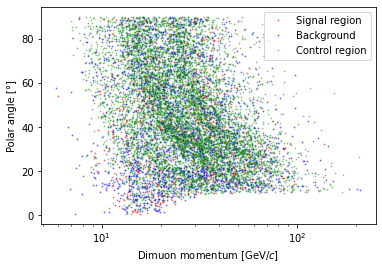

In [6]:
plt.plot (df_sig['p'], df_sig['theta'], '.', alpha=0.4, markersize=2, color='red', label="Signal region")
plt.plot (df_bkg['p'], df_bkg['theta'], '.', alpha=0.4,  markersize=2, color='blue', label="Background")
plt.plot (df_ctrl['p'], df_ctrl['theta'], '.', alpha=0.3,  markersize=2, color='green', label="Control region")
plt.legend()
plt.xscale('log')
plt.xlabel ("Dimuon momentum [GeV/$c$]")
plt.ylabel ("Polar angle [°]")
plt.show()

## Preprocessing 

Instead of using directly the momentum and the angle, we may *preprocess* them in order to make it easier for the minimization procedure to reach the minimum. 
We define two variables `prep_p` and `prep_theta` obtained as a bijective transformation of `p` and `theta` that maps the two variables to distributions "not too different" from a standard Gaussian ($\frac{1}{\sqrt{2\pi}}\exp(-0.5 x^2)$). 

Standardization is a common *preprocessing* procedure:
$$
x' = \frac{x - E(x)}{\sqrt{E^2(x) - E(x)^2}}
$$
where $E$ represents the expectation value (`np.mean`) and the denominator is the standard deviation of the dataset (`np.std`).

For the momentum, the very long tail at high momentum my be difficult to treat even if preprocessed with a linear transform. Hence, we transform the momentum $p$ to $\log (p)$ and then we *standardize* $\log (p)$.

In Python,


In [7]:
p = df['p']
th = df['theta']

df['prep_p'] = (np.log(p) - np.log(p.mean()))/(np.log(np.std(p)))
df['prep_theta'] = (th - th.mean())/(np.std(th))

Let's plot the standardized variables.

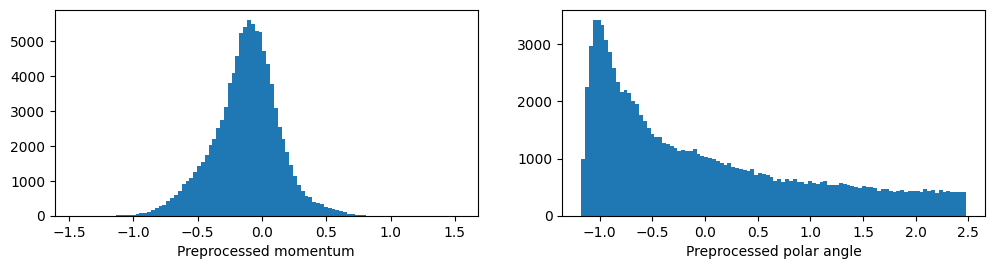

In [8]:
plt.figure (figsize = (12,6), dpi = 100)
plt.subplot(221)
plt.hist (df['prep_p'], bins = 100)
plt.xlabel ("Preprocessed momentum")
plt.subplot(222)

plt.hist (df['prep_theta'], bins = 100)
plt.xlabel ("Preprocessed polar angle")
plt.show()

Finally, we propagate these variables to the dataset obtained through queries to the original dataset, in order to ensure a consistent transoformation of the variables in all the datasets.

In [9]:
df_bkg = df.query ("(M > 2.6 and M < 2.95) or (M > 3.22 and M < 3.5) or (M > 3.85 and M < 4.2)").copy()
df_ctrl = df.query ("M > 3.0 and M < 3.18").copy()
df_sig = df.query ("M > 3.5 and M < 3.9").copy()


## Logistic regression as a special neural network

Let's define a function to instanciate a keras model as discussed in the previous lecture. 
We will take as arguments the number of layers and the number of nodes per layer, assuming all layers share the same number of nodes. 

We will use `tanh` as activation function for the hidden layers which is better suited for small and shallow neural networks, all the other settings are quite standard:
 * Adam optimizer
 * Binary cross-entropy as loss function for binary classification problems

In [10]:
def create_model (n_layers=1, n_nodes=32):
    inputs = K.layers.Input(shape=(2))
    layers = [inputs]
    for iLayer in range(n_layers): 
        layers.append(K.layers.Dense(n_nodes, activation='tanh') (layers[-1]))

    outputs = K.layers.Dense(1, activation = 'sigmoid')(layers[-1])

    model = K.models.Model (inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam')

    return model

Before diving into the depth of the neural network, let's focus on the case 
`n_layers=0`. The resulting algorithm is known as logistic regression. 
Note that since there are no non-linear elements (with the exception of the `sigmoid` which is only applied to the output layer) this is considered as a linear classification algorithm.

The prediction $\hat y$ is defined by
$$
\hat y = \mathrm{sigmoid} ( a p + b \theta + c)
$$
where $a$, $b$ and $c$ are parameters to be optimized during the training, $p$ and $\theta$ are the preprocessed versions of the momentum and polar angle of our dimuon combination.

With `lr.summary()` we obtain confirmation that the total number of parameters defining the model is indeed 3.


In [11]:
lr = create_model (n_layers=0)
lr.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


## Dataset preparation
We are now ready to convert the `pandas` dataframe in `numpy` arrays that can transparently be processed by keras.

First of all, we identify the control sample with unit labels, while the background candidates are identified by null labels. 

Then we use obtain the arrays from pandas using the `values` property, and finally we shuffle the signal and background events by defining a random permutation of the indices and shuffling variables and labels by the same permutation.

In [12]:
df_ctrl['label'] = 1
df_bkg['label'] = 0

X = np.concatenate ( [ df_ctrl[['prep_p', 'prep_theta']].values , df_bkg[['prep_p', 'prep_theta']].values ] ) 
y = np.concatenate ( [ df_ctrl['label'].values , df_bkg['label'].values ] ) 

indices = np.random.permutation (len(X))

X = X[indices]
y = y[indices]

We are finally ready to train the logistic regression on our data.


In [13]:
history_lr=lr.fit (X, y, validation_split=0.5, epochs=150, verbose=True)

Epoch 1/150
152/152 [==============================] - 1s 5ms/step - loss: 0.7422 - val_loss: 0.6902
Epoch 2/150
152/152 [==============================] - 0s 3ms/step - loss: 0.6758 - val_loss: 0.6454
Epoch 3/150
152/152 [==============================] - 1s 4ms/step - loss: 0.6322 - val_loss: 0.6162
Epoch 4/150
152/152 [==============================] - 0s 3ms/step - loss: 0.6045 - val_loss: 0.5988
Epoch 5/150
152/152 [==============================] - 0s 2ms/step - loss: 0.5894 - val_loss: 0.5877
Epoch 6/150
152/152 [==============================] - 0s 2ms/step - loss: 0.5774 - val_loss: 0.5811
Epoch 7/150
152/152 [==============================] - 0s 3ms/step - loss: 0.5673 - val_loss: 0.5773
Epoch 8/150
152/152 [==============================] - 0s 2ms/step - loss: 0.5704 - val_loss: 0.5750
Epoch 9/150
152/152 [==============================] - 0s 3ms/step - loss: 0.5585 - val_loss: 0.5736
Epoch 10/150
152/152 [==============================] - 0s 3ms/step - loss: 0.5672 - val_lo

152/152 [==============================] - 1s 4ms/step - loss: 0.5616 - val_loss: 0.5694
Epoch 82/150
152/152 [==============================] - 0s 3ms/step - loss: 0.5586 - val_loss: 0.5694
Epoch 83/150
152/152 [==============================] - 0s 3ms/step - loss: 0.5611 - val_loss: 0.5694
Epoch 84/150
152/152 [==============================] - 1s 3ms/step - loss: 0.5526 - val_loss: 0.5694
Epoch 85/150
152/152 [==============================] - 1s 4ms/step - loss: 0.5638 - val_loss: 0.5694
Epoch 86/150
152/152 [==============================] - 1s 4ms/step - loss: 0.5503 - val_loss: 0.5694
Epoch 87/150
152/152 [==============================] - 0s 3ms/step - loss: 0.5475 - val_loss: 0.5694
Epoch 88/150
152/152 [==============================] - 1s 3ms/step - loss: 0.5543 - val_loss: 0.5694
Epoch 89/150
152/152 [==============================] - 1s 4ms/step - loss: 0.5494 - val_loss: 0.5693
Epoch 90/150
152/152 [==============================] - 1s 4ms/step - loss: 0.5620 - val_loss: 

Let's plot the evolution of the binary cross-entropy with the epochs.

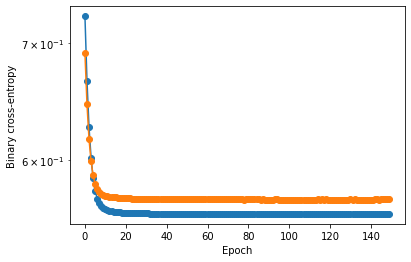

In [14]:
plt.plot (history_lr.history['loss'], 'o-', label="Training")
plt.plot (history_lr.history['val_loss'], 'o-', label="Validation")

plt.yscale('log')
plt.xlabel ( "Epoch")
plt.ylabel ( "Binary cross-entropy")

plt.show()

We observe that the slope at the end of training is basically null, which may indicate that the training procedure reached the minimum of the loss function.

We can then explore the response of the logistic regression.

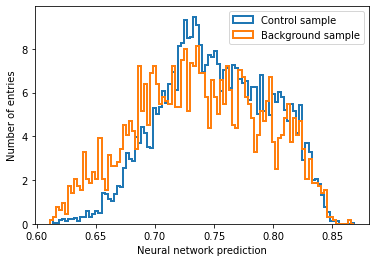

In [15]:
X_ctrl = df_ctrl[['prep_p', 'prep_theta']].values
y_ctrl = lr.predict(X_ctrl)

X_bkg = df_bkg[['prep_p', 'prep_theta']].values
y_bkg = lr.predict(X_bkg)

h_ctrl, boundaries, _ = plt.hist (y_ctrl, density=True, bins=100, label="Control sample", histtype='step', linewidth=2)
h_bkg, _, _ = plt.hist (y_bkg, density=True, bins=boundaries, label="Background sample", histtype='step', linewidth=2)
plt.legend()
plt.xlabel ("Neural network prediction")
plt.ylabel ("Number of entries")
plt.show()

The histogram indicates already the the separation between signal in the control sample and the background is not exciting, but we observe that the histogram representing the control sample is, as expected, slightly at the right of the background. 

It is customary to study the hability of the classification algorithm to distinghish signal from noise using the *Receiver Operator Curve (ROC)*: the curve obtained plotting the background rejection versus the signal efficiency for different working points of the binary classification algorithm.

We plot below the ROC of the Logistic Regression algorithm, superposed to the result expected by drawing randomly events from the dataset and calling them signal events.

The area under the ROC (*Area under the curve*) is a metric of how well the algorithm is able to separate signal and background, independently of the threshold chosen to call a candidate *signal* or *background*.

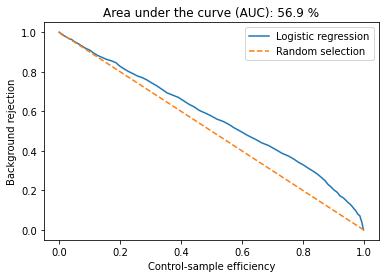

In [16]:
plt.plot (1.- np.cumsum(h_ctrl)/h_ctrl.sum(), np.cumsum(h_bkg)/h_bkg.sum(), label="Logistic regression" )
auc = np.trapz (1.- np.cumsum(h_ctrl)/h_ctrl.sum(), np.cumsum(h_bkg)/h_bkg.sum() )
plt.plot ([1,0], [0,1], '--', label = "Random selection")
plt.xlabel ("Control-sample efficiency")
plt.ylabel ("Background rejection")
plt.title ( f"Area under the curve (AUC): {auc*100:.1f} %")
plt.legend()
plt.show()

Keras allows to obtain the *Area Under the Curve* (AUC) directly as metric for each step of the training, for both training and validation samples.

Let's modify the function `create_model` to include the AUC as metric and let's verify it appears in the training `history`.

In [17]:
def create_model (n_layers=1, n_nodes=32):
    inputs = K.layers.Input(shape=(2))
    layers = [inputs]
    for iLayer in range(n_layers): 
        layers.append(K.layers.Dense(n_nodes, activation='tanh') (layers[-1]))
  
    outputs = K.layers.Dense(1, activation = 'sigmoid')(layers[-1])
   
    model = K.models.Model (inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['AUC'])

    return model


lr_with_auc = create_model (n_layers=0, n_nodes=4)
history_lr=lr_with_auc.fit (X, y, validation_split=0.5, epochs=50, verbose=True)
history_lr.history.keys()

Epoch 1/50
152/152 [==============================] - 1s 5ms/step - loss: 0.8117 - auc: 0.4343 - val_loss: 0.7444 - val_auc: 0.4271
Epoch 2/50
152/152 [==============================] - 0s 3ms/step - loss: 0.7326 - auc: 0.4158 - val_loss: 0.6830 - val_auc: 0.4279
Epoch 3/50
152/152 [==============================] - 1s 4ms/step - loss: 0.6683 - auc: 0.4453 - val_loss: 0.6410 - val_auc: 0.4318
Epoch 4/50
152/152 [==============================] - 1s 4ms/step - loss: 0.6324 - auc: 0.4247 - val_loss: 0.6132 - val_auc: 0.4506
Epoch 5/50
152/152 [==============================] - 1s 4ms/step - loss: 0.6085 - auc: 0.4645 - val_loss: 0.5958 - val_auc: 0.5234
Epoch 6/50
152/152 [==============================] - 1s 4ms/step - loss: 0.5908 - auc: 0.5450 - val_loss: 0.5847 - val_auc: 0.5506
Epoch 7/50
152/152 [==============================] - 1s 4ms/step - loss: 0.5713 - auc: 0.5546 - val_loss: 0.5785 - val_auc: 0.5600
Epoch 8/50
152/152 [==============================] - 1s 4ms/step - loss: 0.

dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])

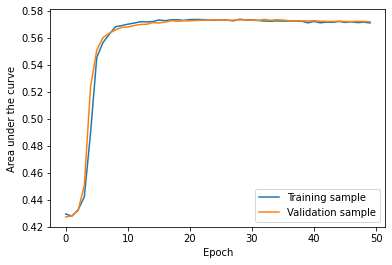

In [18]:
plt.plot(history_lr.history['auc'], label = "Training sample")
plt.plot(history_lr.history['val_auc'], label = "Validation sample")
plt.xlabel ("Epoch")
plt.ylabel ("Area under the curve")
plt.legend()
plt.show()

## Application
We are now ready to apply the trained logistic regression to the signal sample.

First we obtain the prediction `y_hat` for each row of the signal dataframe and register it as a new column of this derived datasets.



In [19]:
X_sig = df_sig[['prep_p', 'prep_theta']].values
y_hat = lr.predict (X_sig).flatten()
df_sig ['y_hat'] = y_hat

Then we plot the histogram and select some threshold to scan the effect of a cut on the response obtained from the logistic regression on the invariant mass distribution.

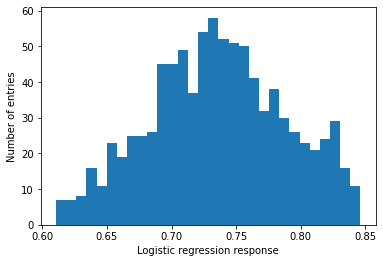

In [20]:
plt.hist (y_hat, bins = 30)
plt.xlabel("Logistic regression response")
plt.ylabel("Number of entries")
plt.show()

We use the function `quantile` to get a sequence of thresholds that divide the sample in equal parts. 

Then we loop over the threshold and draw the histograms obtained by cutting on the logistic regression response.

We note that with the softer cuts we are able to remove background without affecting the signal component.

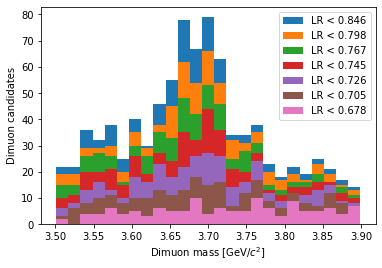

In [21]:
thresholds = np.quantile (y_hat, np.linspace(1, 0, 8))
for threshold in thresholds[:-1]:
    plt.hist (df_sig['M'][y_hat < threshold], bins = 25, label = f"LR < {threshold:.3f}")
plt.legend()
plt.xlabel ("Dimuon mass [GeV/$c^2$]")
plt.ylabel ("Dimuon candidates")
plt.show()

## Choice of the threshold
Once the model is trained we need to define a threshold to reject some events as background and retain more signal than background entries. 

The choice of the optimal threshold depends on the problem we are trying to solve. For example, for a discovery we try to optimize the [Punzi figure of merit](https://arxiv.org/pdf/physics/0308063.pdf) 
$$
\frac{\epsilon_S}{\frac32 + \sqrt{B}}
$$
where $S$ and $B$ rerpresent the number of signal and background candidates obtained with a certain selection strategy, or choice of the threshold.

Let's try to maximise this metric for our problem.

First, we need to define $S$ and $B$ as a function of the threshold applied. 

We identify a pure-background region and a signal box.

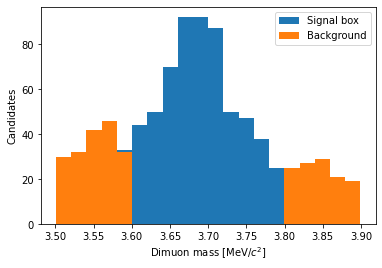

In [22]:
_, boundaries, _ = plt.hist (df_sig['M'], bins = 20, label = "Signal box")
plt.hist (df_sig.query("M<3.6 or M>3.8")['M'], bins = boundaries, label = f"Background")
plt.legend()
plt.xlabel ("Dimuon mass [MeV/$c^2$]")
plt.ylabel ("Candidates")
plt.show()

Then we obtain the histograms of the logistic regression prediction $\hat y$ for the sample in the signal box and in the pure-background regions. 

We can rescale the number of events in the background region to predict the number of events in the signal box based on the length of the two mass intervals. 

Once we have the two histograms, we can compute the number of events with $\hat y < \mathrm{threshold}$ as cumulative sum of the bin contents of the histogram.

The events surviving the selection are those with $\hat y > \mathrm{threshold}$ which are nothing but the total number of events minus those with $\hat y < \mathrm{threshold}$ defined above. 




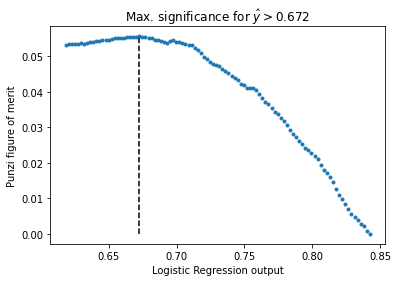

In [23]:
## Compute the histogram of events in the sidebands
bkg_proxy, boundaries = np.histogram(df_sig.query("M<3.6 or M>3.8")['y_hat'], bins = 100)

## Rescale the events in the sidebands to obtain the number of background events in the signal box
nB = bkg_proxy * (3.8-3.6)/(3.6-3.5+3.9-3.8)

## Compute the prediction of the logistic regression for the whole sample
df['y_hat'] = lr.predict(df[['prep_p', 'prep_theta']].values)

## Compute the histogram of events in the signal box (both signal and background) 
nS, _ = np.histogram(df.query("M > 3.0 and M < 3.2")['y_hat'], bins=boundaries)

## Compute the number of events with yhat > threshold
nB = np.sum(nB) - np.cumsum(nB)
effS = (np.sum(nS) - np.cumsum(nS))/np.sum(nS)

## Finally compute the figure of merit effS / ( 1.5 + sqrt (B) ) 
epsilon = 1e-12
fom = effS / (1.5 + np.sqrt(nB + epsilon))

## And determine the best threshold 
xAxis = 0.5 * (boundaries[1:] + boundaries[:-1])
best_threshold = xAxis[np.argmax(fom)]

plt.plot (xAxis, fom, '.')
plt.xlabel("Logistic Regression output")
plt.ylabel("Punzi figure of merit")

plt.title (f"Max. significance for $\hat y > {best_threshold:.3f}$")
plt.plot ([best_threshold, best_threshold], [fom.min(), fom.max()], 'k--')
plt.show()

Finally we draw the histogram obtained with the optimal selection.
In this case, the signal is already quite enhanced and the logistic regression not very effective and therefore the two histograms appear very similar. 

Nonetheless, note we rejected some background almost without affecting the signal component for free.

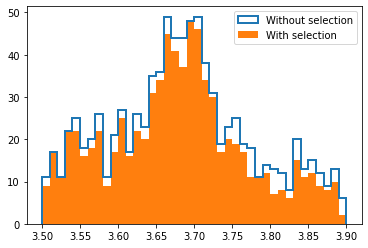

In [24]:
plt.hist (df_sig['M'], bins = np.linspace(3.5, 3.9, 41), histtype='step', label = "Without selection", linewidth=2)

plt.hist (df_sig.query(f'y_hat>{best_threshold}')['M'], bins = np.linspace(3.5, 3.9, 41), label ="With selection")

plt.legend()
plt.show()

## Map of the selection
Since we are using two variables only, we can superpose the decision of the neural network to the distribution of the dataset on the plane $p \perp \theta$.
From this excercise it should be evident the "linearity" of the logistic regression.

> In short, the algorithm (the logistic regression or the neural network) defines the shape of the *boundaries* with the optimization of the figure of merit we select *which* boundary separates the two classes.

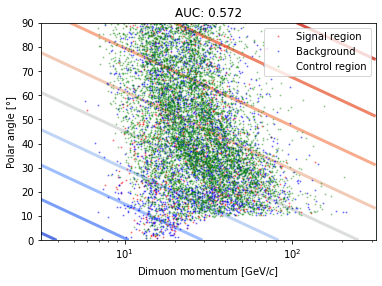

In [25]:
def make_plot (p, theta, yNN):
    plt.plot (df_sig['p'], df_sig['theta'], '.', alpha=0.4, markersize=2, color='red', label="Signal region")
    plt.plot (df_bkg['p'], df_bkg['theta'], '.', alpha=0.4,  markersize=2, color='blue', label="Background")
    plt.plot (df_ctrl['p'], df_ctrl['theta'], '.', alpha=0.3,  markersize=2, color='green', label="Control region")

    plt.contour (p, theta, yNN.reshape(p.shape), cmap='coolwarm', levels=10, alpha=1, linewidths=3)
  
    plt.legend()
    plt.xscale('log')
    plt.xlabel ("Dimuon momentum [GeV/$c$]")
    plt.ylabel ("Polar angle [°]")
    plt.show()

pAxis = 10**np.linspace (0.5, 2.5, 100)
thetaAxis = np.linspace (0, 90, 100)
p, theta = np.meshgrid (pAxis, thetaAxis)

prep_p = (np.log(p) - np.log(df['p'].mean()))/(np.log(np.std(df['p'])))
prep_theta = (theta - theta.mean()) / np.std(theta)

yNN = lr.predict ((np.stack([prep_p.flatten(), prep_theta.flatten()], axis = -1)))
plt.title (f"AUC: {history_lr.history['val_auc'][-1]:.3f}")
make_plot (p, theta, yNN)

## Adding non-linearity: Neural networks

We are ready to add non-linarity to our "fit function" by adding layers to our nerual network.

Let's start with a shallow neural network made of one layer of 16 nodes.

In [26]:
nn = create_model(n_layers=1, n_nodes = 16)
history_nn = nn.fit (X, y, epochs=50, validation_split=0.5, verbose=True)

Epoch 1/50
152/152 [==============================] - 1s 4ms/step - loss: 0.6352 - auc: 0.5441 - val_loss: 0.5720 - val_auc: 0.5716
Epoch 2/50
152/152 [==============================] - 0s 2ms/step - loss: 0.5608 - auc: 0.5817 - val_loss: 0.5664 - val_auc: 0.5712
Epoch 3/50
152/152 [==============================] - 1s 3ms/step - loss: 0.5555 - auc: 0.5762 - val_loss: 0.5659 - val_auc: 0.5704
Epoch 4/50
152/152 [==============================] - 1s 5ms/step - loss: 0.5463 - auc: 0.5629 - val_loss: 0.5658 - val_auc: 0.5704
Epoch 5/50
152/152 [==============================] - 1s 4ms/step - loss: 0.5664 - auc: 0.5631 - val_loss: 0.5662 - val_auc: 0.5705
Epoch 6/50
152/152 [==============================] - 1s 3ms/step - loss: 0.5425 - auc: 0.5692 - val_loss: 0.5655 - val_auc: 0.5698
Epoch 7/50
152/152 [==============================] - 1s 4ms/step - loss: 0.5508 - auc: 0.5466 - val_loss: 0.5654 - val_auc: 0.5702
Epoch 8/50
152/152 [==============================] - 1s 4ms/step - loss: 0.

We should ensure we are far from over training and that the training is advanced enough by checking the evolution of the loss function of both the validation and training data sets.

We will define a function `plot_loss` to make it faster to plot the loss for the next steps.

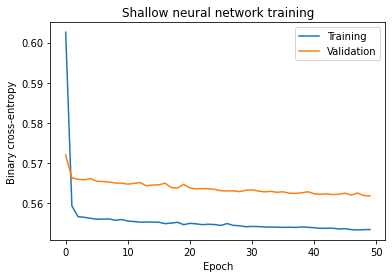

In [27]:
def plot_loss (history, title="Loss"):
    plt.plot (history.history['loss'], '-', label="Training")
    plt.plot (history.history['val_loss'], '-', label="Validation")
    plt.xlabel ("Epoch")
    plt.ylabel ("Binary cross-entropy")
    plt.legend()
    plt.title (title)

plot_loss (history_nn, title = "Shallow neural network training")
plt.show()

Finally we can check the effect on the plane $p \perp \theta$ and see the effect of the non-linearity in action.

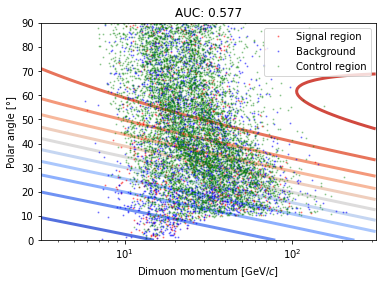

In [28]:
prep_p = (np.log(p) - np.log(df['p'].mean()))/(np.log(np.std(df['p'])))
prep_theta = (theta - theta.mean()) / np.std(theta)

yNN = nn.predict ((np.stack([prep_p.flatten(), prep_theta.flatten()], axis = -1)))

plt.title (f"AUC: {history_nn.history['val_auc'][-1]:.3f}")
make_plot (p, theta, yNN)

## Going deep
The more the layers and the nodes the more complex the fit function is. 

Let's see what happens with 3 layers of 16 nodes each.

Epoch 1/50
152/152 [==============================] - 2s 5ms/step - loss: 0.5864 - auc: 0.5779 - val_loss: 0.5665 - val_auc: 0.5727
Epoch 2/50
152/152 [==============================] - 0s 3ms/step - loss: 0.5579 - auc: 0.5577 - val_loss: 0.5645 - val_auc: 0.5712
Epoch 3/50
152/152 [==============================] - 1s 3ms/step - loss: 0.5654 - auc: 0.5377 - val_loss: 0.5635 - val_auc: 0.5722
Epoch 4/50
152/152 [==============================] - 1s 3ms/step - loss: 0.5543 - auc: 0.5486 - val_loss: 0.5632 - val_auc: 0.5726
Epoch 5/50
152/152 [==============================] - 1s 3ms/step - loss: 0.5624 - auc: 0.5668 - val_loss: 0.5640 - val_auc: 0.5720
Epoch 6/50
152/152 [==============================] - 0s 3ms/step - loss: 0.5697 - auc: 0.5603 - val_loss: 0.5625 - val_auc: 0.5753
Epoch 7/50
152/152 [==============================] - 0s 3ms/step - loss: 0.5486 - auc: 0.5738 - val_loss: 0.5621 - val_auc: 0.5722
Epoch 8/50
152/152 [==============================] - 0s 3ms/step - loss: 0.

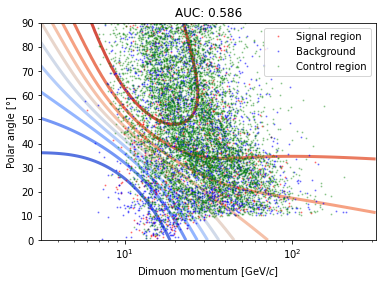

In [29]:
dnn = create_model(n_layers=3, n_nodes = 16)
history_dnn = dnn.fit (X, y, epochs=50, validation_split=0.5, verbose=True)
prep_p = (np.log(p) - np.log(df['p'].mean()))/(np.log(np.std(df['p'])))
prep_theta = (theta - theta.mean()) / np.std(theta)

yNN = dnn.predict ((np.stack([prep_p.flatten(), prep_theta.flatten()], axis = -1)))

plt.title (f"AUC: {history_dnn.history['val_auc'][-1]:.3f}")
make_plot (p, theta, yNN)

The improvement in terms of AUC seems significant but we can easily imagine more complex functions with that many free parameters. 

The problem is that most of the network is not used and the local minimum where the training stops is far from the global minimum of the minimization. 

When going deep, the initialization of the layer weights may become critical. 



## Pushing the limit: *hyper-parameter tuning*

The initialization of the layer weights is however only one of the many aspects of the neural network that can be tuned to improve its performance. 

In the following we amused ourselves to try to push a bit the neural network training to improve its classification score.
We redefined the function `create_model` to add a custom initialization of the weights of the layers and modify the learning rate of the Adam optimizer. 

In [30]:
def create_model_advanced (n_layers=1, n_nodes=32):
    inputs = K.layers.Input(shape=(2))
    layers = [inputs]
    for iLayer in range(n_layers): 
      layers.append(K.layers.Dense(n_nodes, activation='tanh', kernel_initializer='he_normal', bias_initializer='zeros') (layers[-1]))

    outputs = K.layers.Dense(1, activation = 'sigmoid')(layers[-1])

    model = K.models.Model (inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer=K.optimizers.Adam(1.5e-3), metrics=['AUC'])

    return model

Then we define a 2-layer deep neural network with 64 nodes per layer and train it for 100 epochs (these are all hyperparameters).

The resulting segmentation of the $p \perp \theta$ plane is significantly more complicated, but it still generalizes properly to the validation dataset.

Epoch 1/100
49/49 [==============================] - 1s 14ms/step - loss: 0.6229 - auc: 0.5588 - val_loss: 0.5632 - val_auc: 0.5703
Epoch 2/100
49/49 [==============================] - 0s 7ms/step - loss: 0.5636 - auc: 0.5439 - val_loss: 0.5619 - val_auc: 0.5707
Epoch 3/100
49/49 [==============================] - 0s 7ms/step - loss: 0.5472 - auc: 0.5531 - val_loss: 0.5667 - val_auc: 0.5720
Epoch 4/100
49/49 [==============================] - 0s 5ms/step - loss: 0.5557 - auc: 0.5598 - val_loss: 0.5667 - val_auc: 0.5792
Epoch 5/100
49/49 [==============================] - 0s 6ms/step - loss: 0.5543 - auc: 0.5821 - val_loss: 0.5620 - val_auc: 0.5795
Epoch 6/100
49/49 [==============================] - 0s 7ms/step - loss: 0.5416 - auc: 0.5692 - val_loss: 0.5622 - val_auc: 0.5753
Epoch 7/100
49/49 [==============================] - 0s 7ms/step - loss: 0.5553 - auc: 0.5703 - val_loss: 0.5606 - val_auc: 0.5734
Epoch 8/100
49/49 [==============================] - 0s 7ms/step - loss: 0.5547 - 

49/49 [==============================] - 0s 7ms/step - loss: 0.5501 - auc: 0.5881 - val_loss: 0.5599 - val_auc: 0.5846
Epoch 64/100
49/49 [==============================] - 0s 5ms/step - loss: 0.5473 - auc: 0.5998 - val_loss: 0.5609 - val_auc: 0.5821
Epoch 65/100
49/49 [==============================] - 0s 6ms/step - loss: 0.5423 - auc: 0.5963 - val_loss: 0.5609 - val_auc: 0.5813
Epoch 66/100
49/49 [==============================] - 0s 6ms/step - loss: 0.5457 - auc: 0.5735 - val_loss: 0.5607 - val_auc: 0.5815
Epoch 67/100
49/49 [==============================] - 0s 6ms/step - loss: 0.5546 - auc: 0.5778 - val_loss: 0.5614 - val_auc: 0.5787
Epoch 68/100
49/49 [==============================] - 0s 7ms/step - loss: 0.5484 - auc: 0.5832 - val_loss: 0.5611 - val_auc: 0.5836
Epoch 69/100
49/49 [==============================] - 0s 7ms/step - loss: 0.5508 - auc: 0.5825 - val_loss: 0.5604 - val_auc: 0.5822
Epoch 70/100
49/49 [==============================] - 0s 6ms/step - loss: 0.5525 - auc: 0

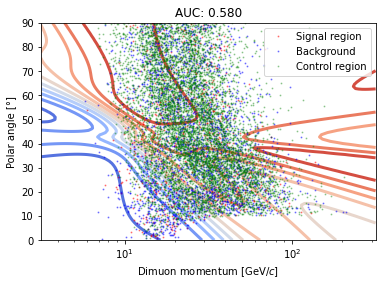

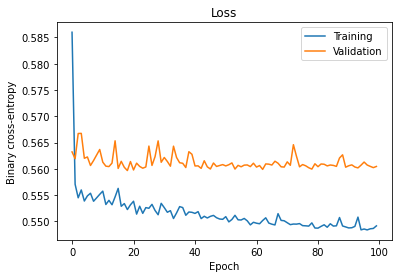

In [31]:
dnn = create_model_advanced(n_layers=2, n_nodes = 64)
history_dnn = dnn.fit (X, y, epochs=100, validation_split=0.5, verbose=True, batch_size=100)
prep_p = (np.log(p) - np.log(df['p'].mean()))/(np.log(np.std(df['p'])))
prep_theta = (theta - theta.mean()) / np.std(theta)

yNN = dnn.predict ((np.stack([prep_p.flatten(), prep_theta.flatten()], axis = -1)))

plt.title (f"AUC: {history_dnn.history['val_auc'][-1]:.3f}")
make_plot (p, theta, yNN)
plt.show()
plot_loss (history_dnn)

## Breaking the limit: *overtraining*

While tuning the hyperparameters it may happen that the function becomes so complicated that it can fit the single signal and background entries in the training sample, loosing any generalization power on the validation sample.
In this case we talk of *overtraining*.

Overtraining is often seen as bad thing in machine learning. 
However, reaching overtraining and then fighting against it is a good strategy when designing a neural network because a poorly designed neural network or a choice of hyperparameters too far from optimum will result in **undertraining** even if a large number of free parameters is used (as in the example of the 3-layer deep neural network above).

Clearly, you should **never rely on the efficiency and rejection evaluated on the training sample**. 

Epoch 1/150
49/49 [==============================] - 1s 12ms/step - loss: 0.6149 - auc: 0.5538 - val_loss: 0.5682 - val_auc: 0.5731
Epoch 2/150
49/49 [==============================] - 0s 7ms/step - loss: 0.5554 - auc: 0.5801 - val_loss: 0.5739 - val_auc: 0.5217
Epoch 3/150
49/49 [==============================] - 0s 7ms/step - loss: 0.5577 - auc: 0.5543 - val_loss: 0.5704 - val_auc: 0.5846
Epoch 4/150
49/49 [==============================] - 0s 5ms/step - loss: 0.5574 - auc: 0.5784 - val_loss: 0.5610 - val_auc: 0.5859
Epoch 5/150
49/49 [==============================] - 0s 6ms/step - loss: 0.5557 - auc: 0.5748 - val_loss: 0.5622 - val_auc: 0.5813
Epoch 6/150
49/49 [==============================] - 0s 7ms/step - loss: 0.5515 - auc: 0.5888 - val_loss: 0.5629 - val_auc: 0.5887
Epoch 7/150
49/49 [==============================] - 0s 8ms/step - loss: 0.5518 - auc: 0.5641 - val_loss: 0.5599 - val_auc: 0.5862
Epoch 8/150
49/49 [==============================] - 0s 7ms/step - loss: 0.5630 - 

49/49 [==============================] - 0s 8ms/step - loss: 0.5510 - auc: 0.5839 - val_loss: 0.5628 - val_auc: 0.5872
Epoch 64/150
49/49 [==============================] - 0s 8ms/step - loss: 0.5430 - auc: 0.5644 - val_loss: 0.5625 - val_auc: 0.5852
Epoch 65/150
49/49 [==============================] - 0s 8ms/step - loss: 0.5480 - auc: 0.5953 - val_loss: 0.5606 - val_auc: 0.5880
Epoch 66/150
49/49 [==============================] - 0s 7ms/step - loss: 0.5404 - auc: 0.5924 - val_loss: 0.5602 - val_auc: 0.5837
Epoch 67/150
49/49 [==============================] - 0s 7ms/step - loss: 0.5443 - auc: 0.5811 - val_loss: 0.5615 - val_auc: 0.5825
Epoch 68/150
49/49 [==============================] - 0s 8ms/step - loss: 0.5593 - auc: 0.5933 - val_loss: 0.5620 - val_auc: 0.5859
Epoch 69/150
49/49 [==============================] - 0s 7ms/step - loss: 0.5408 - auc: 0.5781 - val_loss: 0.5610 - val_auc: 0.5772
Epoch 70/150
49/49 [==============================] - 0s 7ms/step - loss: 0.5379 - auc: 0

Epoch 125/150
49/49 [==============================] - 0s 7ms/step - loss: 0.5507 - auc: 0.5982 - val_loss: 0.5644 - val_auc: 0.5793
Epoch 126/150
49/49 [==============================] - 0s 8ms/step - loss: 0.5395 - auc: 0.5908 - val_loss: 0.5637 - val_auc: 0.5837
Epoch 127/150
49/49 [==============================] - 0s 8ms/step - loss: 0.5394 - auc: 0.6038 - val_loss: 0.5638 - val_auc: 0.5882
Epoch 128/150
49/49 [==============================] - 0s 8ms/step - loss: 0.5415 - auc: 0.5896 - val_loss: 0.5644 - val_auc: 0.5775
Epoch 129/150
49/49 [==============================] - 0s 8ms/step - loss: 0.5373 - auc: 0.5901 - val_loss: 0.5642 - val_auc: 0.5784
Epoch 130/150
49/49 [==============================] - 0s 8ms/step - loss: 0.5295 - auc: 0.5918 - val_loss: 0.5622 - val_auc: 0.5871
Epoch 131/150
49/49 [==============================] - 0s 8ms/step - loss: 0.5340 - auc: 0.5975 - val_loss: 0.5618 - val_auc: 0.5843
Epoch 132/150
49/49 [==============================] - 0s 8ms/step - 

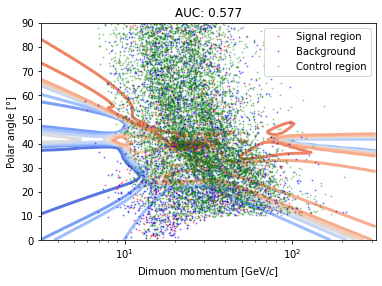

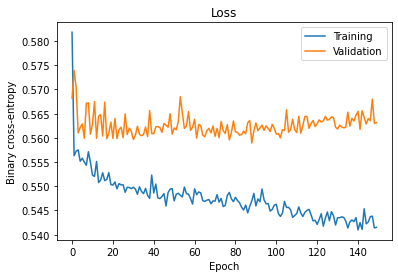

In [32]:
dnn = create_model_advanced(n_layers=5, n_nodes = 64)
history_dnn = dnn.fit (X, y, epochs=150, validation_split=0.5, verbose=True, batch_size=100)
prep_p = (np.log(p) - np.log(df['p'].mean()))/(np.log(np.std(df['p'])))
prep_theta = (theta - theta.mean()) / np.std(theta)

yNN = dnn.predict ((np.stack([prep_p.flatten(), prep_theta.flatten()], axis = -1)))

plt.title (f"AUC: {history_dnn.history['val_auc'][-1]:.3f}")
make_plot (p, theta, yNN)
plot_loss (history_dnn)

# Conclusion

Neural networks are a powerful algorithm to approximate functions, including non-linear classifiers. 
In this notebook we have discussed some basics of the statistics that should lead the design of a classification algorithm.
We discussed the logistic regression as a special case of a neural network without layers, then we added one layer to design a shallow neural network and then another two layers to get a deep neural network.

Depth is not enough, however. With a refinement of the initialization of the weights defining the two layers we have seen that we can improve the performance of the classifier. 

Finally we have seen an example of overtraining. Overtraining is generally a bad thing, but it makes it evident that the learning capability of the network is not limited by the choice of the hyperparameters or by its architecture, but rather on the limited amount of data used for the training. 

This is usually a good starting point to design and tune a powerful neural network capable of generalization.